<a href="https://colab.research.google.com/github/kyle-gao/GRSS_TrackMSD2021/blob/main/ClassicalChangeDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [87]:
import numpy as np
import gdal
import matplotlib.pyplot as plt

In [2]:
!wget https://dfc2021.blob.core.windows.net/competition-data/nlcd-2013/2792_nlcd-2013.tif
!wget https://dfc2021.blob.core.windows.net/competition-data/nlcd-2016/2792_nlcd-2016.tif
!wget https://dfc2021.blob.core.windows.net/competition-data/naip-2013/2792_naip-2013.tif
!wget https://dfc2021.blob.core.windows.net/competition-data/naip-2017/2792_naip-2017.tif

--2020-12-27 23:31:59--  https://dfc2021.blob.core.windows.net/competition-data/nlcd-2013/2792_nlcd-2013.tif
Resolving dfc2021.blob.core.windows.net (dfc2021.blob.core.windows.net)... 52.239.169.100
Connecting to dfc2021.blob.core.windows.net (dfc2021.blob.core.windows.net)|52.239.169.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 524021 (512K) [application/octet-stream]
Saving to: ‘2792_nlcd-2013.tif’

2792_nlcd-2013.tif  100%[===================>] 511.74K  --.-KB/s    in 0.01s   

2020-12-27 23:31:59 (42.8 MB/s) - ‘2792_nlcd-2013.tif’ saved [524021/524021]

--2020-12-27 23:31:59--  https://dfc2021.blob.core.windows.net/competition-data/nlcd-2016/2792_nlcd-2016.tif
Resolving dfc2021.blob.core.windows.net (dfc2021.blob.core.windows.net)... 52.239.169.100
Connecting to dfc2021.blob.core.windows.net (dfc2021.blob.core.windows.net)|52.239.169.100|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 525158 (513K) [application/octet-stream

In [49]:
naip2013 = gdal.Open("/content/2792_naip-2013.tif").ReadAsArray().transpose([1,2,0]).astype(float)
naip2017 = gdal.Open("/content/2792_naip-2017.tif").ReadAsArray().transpose([1,2,0]).astype(float)

#Normalized vegetation difference index NVDI

Good for identifying vegetation and change thereof

nvdi = (nir-red)/(nir+red)

In [16]:
np.seterr(divide='ignore', invalid='ignore')
nvdi2013 = (naip2013[:,:,3]-naip2013[:,:,0])/(naip2013[:,:,3]+naip2013[:,:,0])
nvdi2017 = (naip2017[:,:,3]-naip2017[:,:,0])/(naip2017[:,:,3]+naip2017[:,:,0])

In [50]:
def getnvdi (naip):
  nvdi =  np.divide(naip[:,:,3].astype(float)-naip[:,:,0].astype(float),naip[:,:,3]+naip[:,:,0],where = (naip[:,:,3]-naip[:,:,0])!=0)
  nvdi [nvdi==0]=-1000
  return nvdi

In [51]:
nvdi2013 = getnvdi(naip2013)
nvdi2017 = getnvdi(naip2017)

In [108]:
def plotnvdi(image, cmap="YlGn", vmin=-1,vmax=1,figsize=(15,15)):
  plt.figure(figsize=figsize)
  plot = plt.imshow(image,vmin=vmin,cmap=cmap,vmax=vmax)
  plt.colorbar(plot,fraction=0.015)
  plt.show()

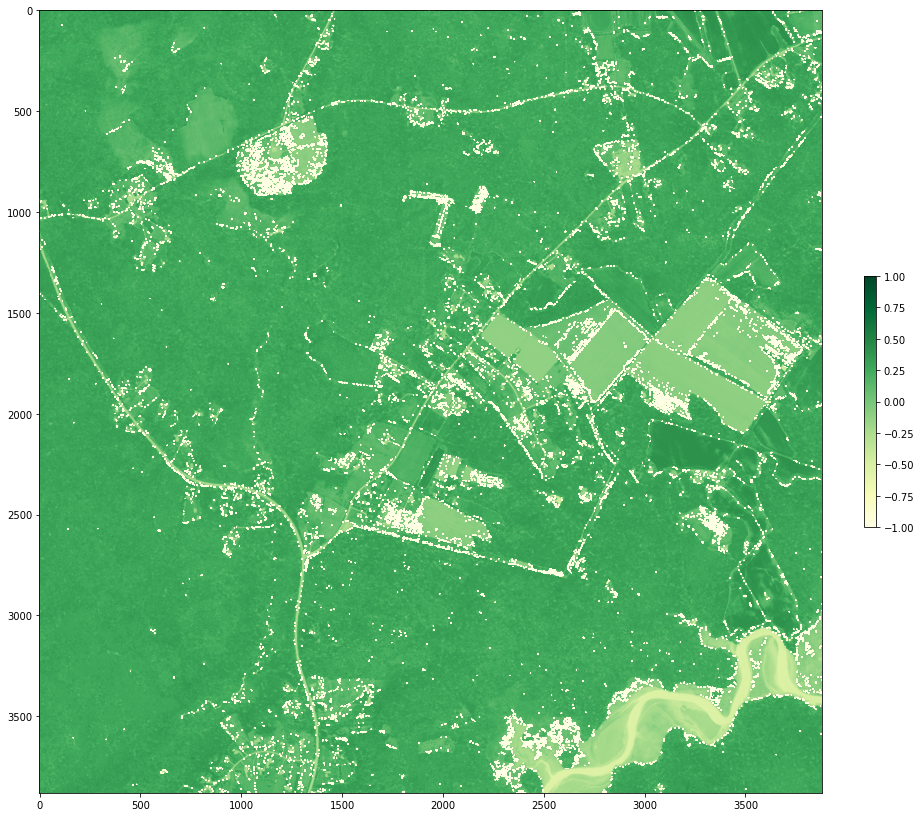

In [53]:
plotnvdi(nvdi2013)

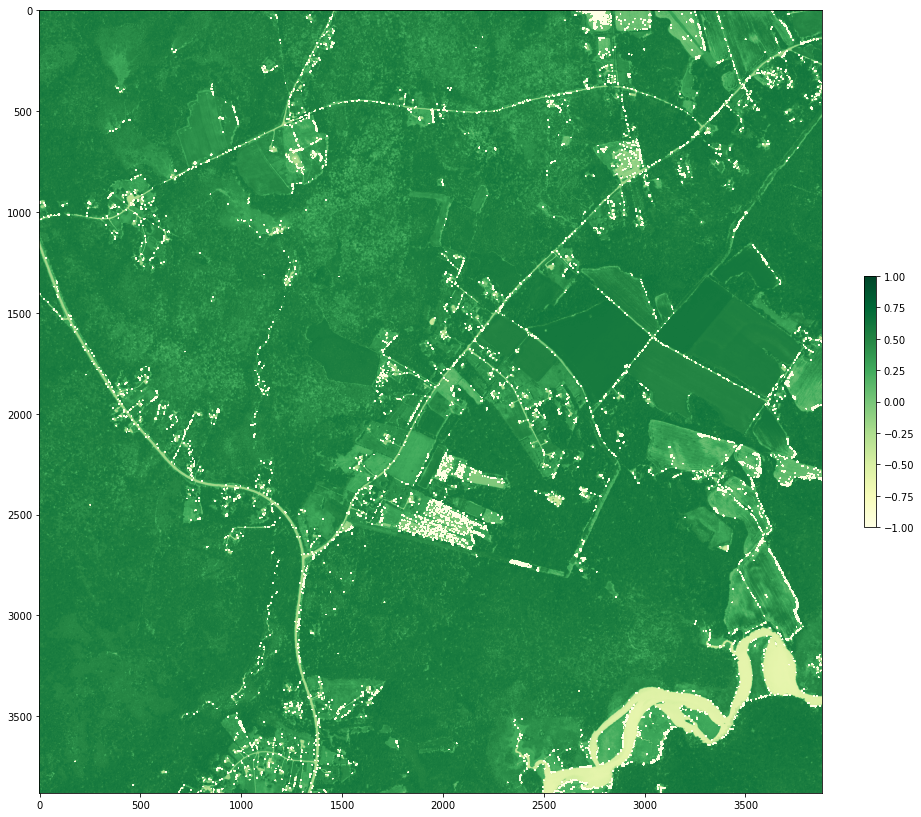

In [54]:
plotnvdi(nvdi2017)

In [55]:
nvdichange = abs(nvdi2013-nvdi2017)

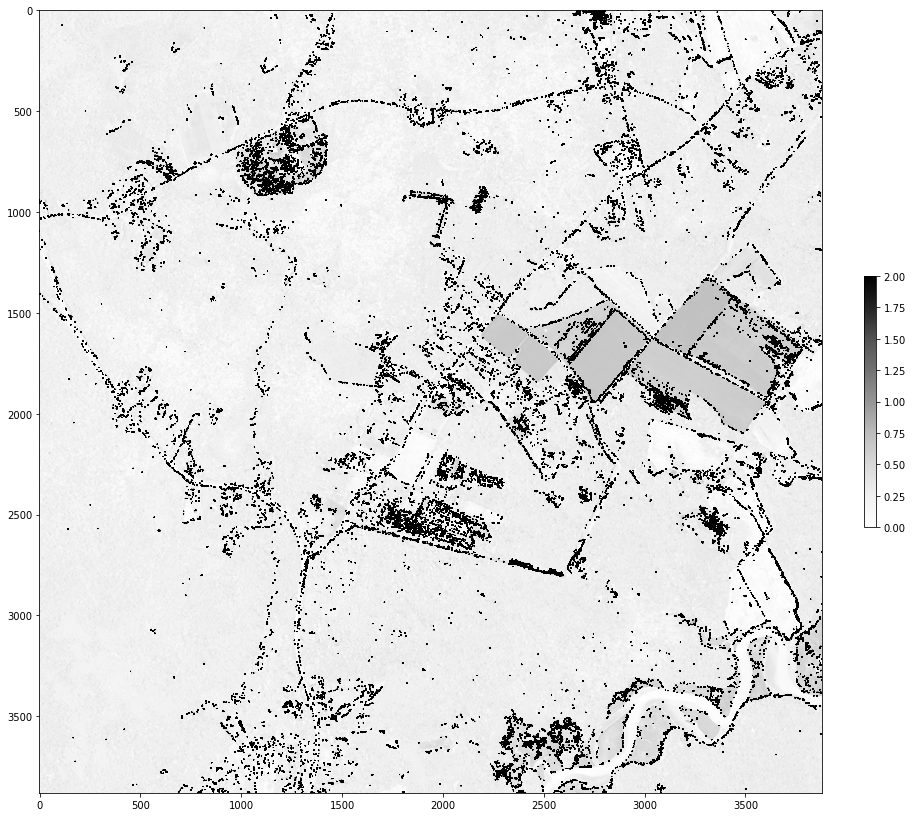

In [56]:
plotnvdi(nvdichange,cmap="Greys",vmin=0,vmax=2)

#Principal component analysis PCA

do it for each band

In [62]:
from sklearn.decomposition import PCA

In [63]:
imgdiff = np.abs(naip2017-naip2013)[-1000:,-1000:,:]

##tile the image

In [64]:
def img_to_flat_tiles(image,tilesize=(5,5)):
  """returns a list of tiles flattened into 1d arrays from a single band image, normalized by its mean"""
  #I can probably write a vectorized version for speed
  (M,N) = image.shape
  (m,n) = tilesize
  tiles = [image[x:x+m,y:y+n].ravel() for x in range(0,M,m) for y in range(0,N,n)]
  mean = np.mean(tiles,axis=0)
  return (tiles-mean), mean

In [65]:
band3tiles, band3mean = img_to_flat_tiles(imgdiff[:,:,3])

##calculate principal components of tiles

In [66]:
pca = PCA()
pca.fit(band3tiles)
EigenvecMatrix = pca.components_

##create feature vectors (5x5 flattened) at each pixels
should really pad the image here

In [67]:
def img_to_feature_tiles(image):
  """returns a list of tiles flattened into 1d arrays from a single band image, normalized by its mean, mapped to PCA-eigenvector coordinates"""
  #I can probably write a vectorized version for speed
  (M,N) = image.shape
  tiles = [np.dot(image[x-2:x+3,y-2:y+3].ravel(),EigenvecMatrix) for x in range(2,M-2) for y in range(2,N-2)]
  mean = np.dot(np.mean(tiles,axis=0),EigenvecMatrix)
  return (tiles-mean), mean

In [91]:
pad=2
paddeddiff  = np.pad(imgdiff,[(pad,pad),(pad,pad),(0,0)])
np.shape(paddeddiff)

(1004, 1004, 4)

In [92]:
band3features,meanfeature = img_to_feature_tiles(paddeddiff[:,:,3])

In [93]:
np.shape(band3features)

(1000000, 25)

In [94]:
from sklearn.cluster import KMeans
from collections import Counter

##use kmeans to cluster changed and unchanged pixels

In [109]:
def clustermap(features, K=3,imgsize=(1004,1004)):
  #apparently 3 clusters works better than 2
  #least index is the cluster that appears least often, corresponding to change cluster
  kmeans = KMeans(K, verbose = 0)
  kmeans.fit(features)
  pred = kmeans.predict(features)
  count = Counter(pred)
  least_index = min(count, key = count.get)
  change_map = np.reshape(pred,(imgsize[0] - 4, imgsize[1] - 4))
  return least_index, change_map


In [110]:
index, map = clustermap(band3features)

In [111]:
map[map==index]=1
map[map!=1]=0

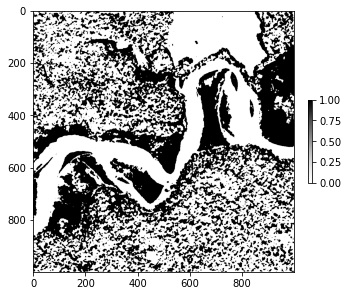

In [114]:
plotnvdi(map,cmap="Greys",vmax=1,vmin=0,figsize=(5,5))